# Experimental Design for Compton Scattering

This notebook produces coefficient figures in the main text of _Designing Optimal Experiments: An Application to Proton Compton Scattering_ by Jordan Melendez, Dick Furnstahl, Harald Grießhammer, Judith McGovern, Daniel Phillips, and Matt Pratola  (see [[arXiv:2004.11307]](https://arxiv.org/abs/2004.11307)). 
The figures are output to `./manuscript_figures/`.
All the other figures can be found in the `./main_manuscript_analysis.ipynb` and `./order_exponent_analysis.ipynb` notebooks.
Most of the detailed code resides in the `compton` package.

This notebook uses modules from standard Python packages, plotly, gptools, and the local `compton` package (install from the root directory of the repository with `pip install -e .`). 


#### Table of contents

1. [Set up kernel parameters](#kernel_parameters) 
1. [Read in data](#import_data)
1. [Truncation error size \[fig. 11\]](#truncation_error)
1. [Coefficient slices \[figs. 12-18\]](#coefficient_slices)
1. [Observable coefficients \[fig. 1\]](#observable_coefficients)


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.special import expit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from os import path
from itertools import product

import plotly as py
import plotly.graph_objects as go
import plotly.express as px

import gptools

from compton import expansion_parameter, expansion_parameter_momentum_transfer_cm, order_transition, coefficients
from compton import expansion_parameter_cm
from compton import mass_proton, mass_neutron, omega_cm_from_lab, mass_pion, mass_delta
from compton import create_observable_set
from compton import omega_lab_cusp
from compton import observables_unique
from compton import ref_scale
from compton import observables_name_map
from compton import setup_rc_params
from compton import dsg_label
from compton import compute_expansion_summation_matrix
from compton import expansion_parameter_phillips
from compton import dsg_label

## Set up the defaults for figures

Set up global plot settings.

In [3]:
setup_rc_params()

## Set up kernel parameters<a id="kernel_parameters"></a>

In [4]:
kernel_kwargs = {
    ('dsg', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
    ('1X', 'proton'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('1Z', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('2X', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=8),
    ('2Z', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
    ('3', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('3Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('3Yp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('1Xp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
    ('1Zp', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
    ('2Xp', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=12),
    ('2Zp', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0], height=4),
    #
    ('dsg', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('1X', 'neutron'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Z', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2X', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Z', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
    ('3', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('3Yp', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Xp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('1Zp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
    ('2Xp', 'neutron'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=None),
    ('2Zp', 'neutron'): dict(std=1.5, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0], height=None),
}

## Read in data<a id="import_data"></a>

In [5]:
observables_name_inverse_map = {val: key for key, val in observables_name_map.items()}

In [6]:
df = pd.read_csv('../data/compton_observables_new.csv', index_col=False)
df['observable'] = df['observable'].replace(observables_name_map)
# observables_unique = df['observable'].unique()

obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df_ratio = pd.read_csv(obs_file, dtype={'observable': str})
df_ratio['observable'] = df_ratio['observable'].replace(observables_name_map)
df_ratio['nucleon'] = df_ratio['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

compton_obs = create_observable_set(df=df_ratio, cov_exp=0.)

# obs vals: crosssection, 1Xp, 1X, 1Zp, 1Z, 2Xp, 2X, 2Zp, 2Z, 3, 3Yp, 3Y, Y
obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]
# obs_vals = observables_unique
# obs_vals = [
#     'crosssection'
# ]
systems = ['Neutron', 'Proton']
order_map = {0: 0, 2: 1, 3: -1, 4: 2}
orders = np.array([0, 2, 3, 4])

# heights = [
#     150, 4, 4, 4, 4, 10, 8, 4, 3, 4, 4, 8, 4
# ]
# heights_dict = {obs: height for obs, height in zip(obs_vals, heights)}

scale_ref = True


# def ref_scale(omega, omega_pi, height, width=50):
#     return 1 / ((omega - omega_pi)**2/width**2 + 1/(height-1)) + 1

In [7]:
df_dsg_ref = pd.read_csv('../data/yref-dsg.csv', index_col=False)
# df_dsg_ref['nucleon'] = df_dsg_ref['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

In [8]:
omega = df['omegalab [MeV]'].unique()
theta = df['thetalab [deg]'].unique()

In [9]:
from gsum import cartesian

In [10]:
X = cartesian(omega, theta)

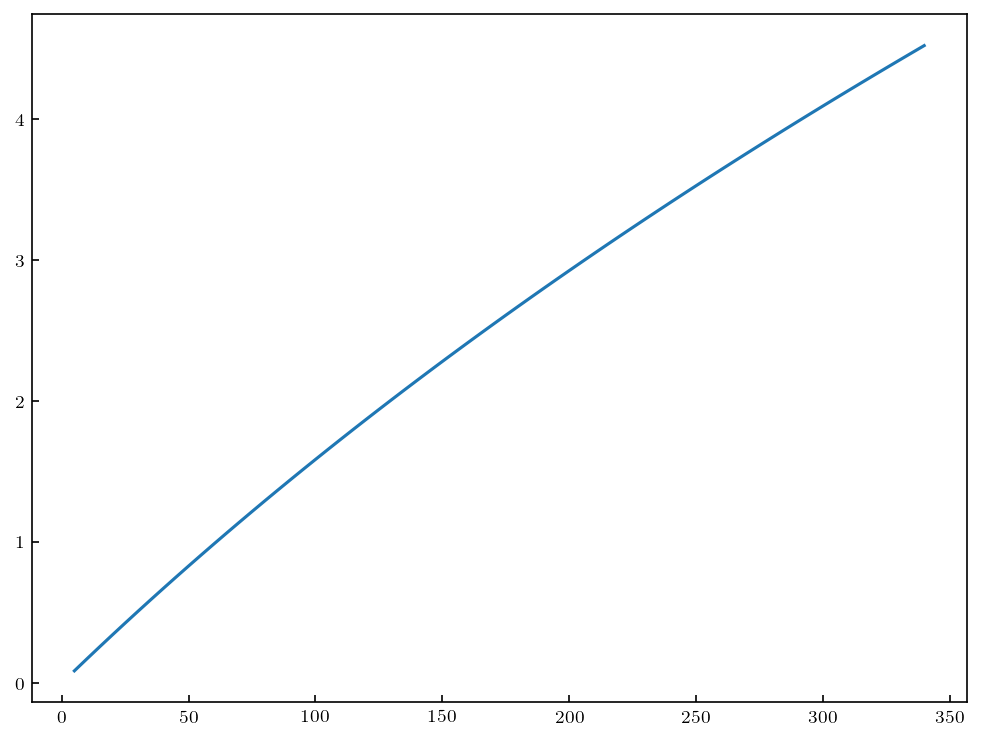

In [11]:
from compton import momentum_transfer_cm, omega_cm_from_lab, mass_proton
q_cm_test = momentum_transfer_cm(omega_cm_from_lab(omega, mass=mass_proton), np.cos(np.deg2rad(1)))
plt.plot(omega, q_cm_test)

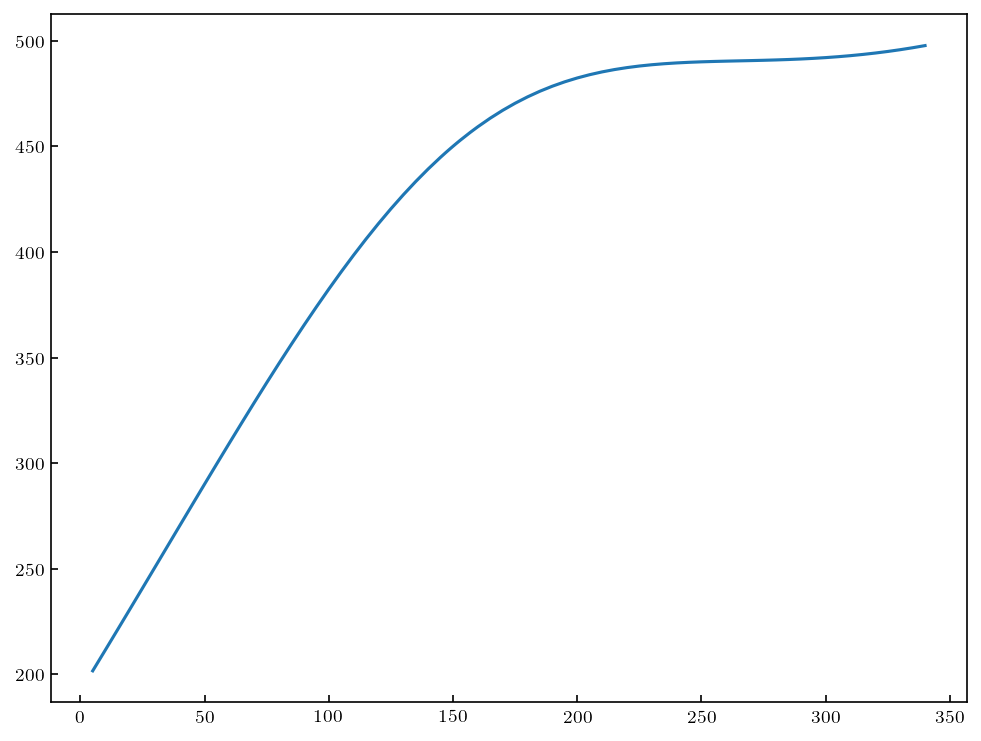

In [12]:
# fwhm = 100
# lorentz = 3000 * fwhm / ((omega - 150)**2 + (0.5 * fwhm)**2)

height = 300
omega_width = 200
cos0_width = 1
lorentz = height / (
        ((omega - 150) / omega_width) ** 2 + 1
)

plt.plot(omega, omega + lorentz)

In [13]:
omega

array([  5.       ,  10.       ,  15.       ,  20.       ,  25.       ,
        30.       ,  35.       ,  40.       ,  45.       ,  50.       ,
        55.       ,  60.       ,  65.       ,  70.       ,  75.       ,
        80.       ,  85.       ,  90.       ,  95.       , 100.       ,
       105.       , 110.       , 115.       , 120.       , 125.       ,
       130.       , 135.       , 140.       , 145.       , 147.       ,
       148.       , 149.       , 149.9506926, 151.       , 152.       ,
       153.       , 157.       , 160.       , 165.       , 170.       ,
       175.       , 180.       , 185.       , 190.       , 195.       ,
       200.       , 205.       , 210.       , 215.       , 220.       ,
       225.       , 230.       , 235.       , 240.       , 245.       ,
       250.       , 255.       , 260.       , 265.       , 270.       ,
       275.       , 280.       , 285.       , 290.       , 295.       ,
       300.       , 305.       , 310.       , 315.       , 320. 

In [14]:
omega.shape

(74,)

In [15]:
Lambdab = 650

# R_script = (mass_delta - mass_proton) / Lambdab
# delta_omega = df['omegalab [MeV]'] / Lambdab
# Q_vals_phillips = np.vstack([
#     np.ones_like(delta_omega),
#     delta_omega ** 1 * R_script,
#     delta_omega ** 2 * R_script,
#     delta_omega ** 3 * R_script ** 2 * (mass_delta - mass_proton) / mass_pion,
#     delta_omega ** 3 * R_script ** 2
# ])

In [16]:
mass_delta - mass_proton

293.72799999999995

In [17]:
mass_pion / mass_delta

0.11201298701298701

In [18]:
mass_delta / Lambdab

1.8953846153846154

In [19]:
np.sqrt(mass_pion * Lambdab)

299.4995826374387

In [20]:
# omega_plot = 170
# theta_plot = 30

# omega_plot2 = 250
# theta_plot2 = 90
# # system = 'proton'

# from itertools import product
# with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
#     for obs, system in product(observables_unique, ['proton', 'neutron']):
#         obs_no_tex = observables_name_inverse_map[obs]
#         height = kernel_kwargs[obs_no_tex, system]['height']
#         width = 150 if obs == dsg_label else 50
#         width_degrees = 90 if obs == dsg_label else np.inf
#         df_i = df[(df['observable'] == obs) & (df['nucleon'] == system)]
#         X = df_i[['omegalab [MeV]', 'thetalab [deg]']].values
#         y = df_i[['y0', 'y2', 'y3', 'y4']].values
        
#         ref = 1.
#         if obs == dsg_label:
# #             ref = df_i['y4'].values
#             ref = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values
# #             ref = df_i['y4'].values
        
#         if obs != dsg_label:
#             df_dsg = df[(df['observable'] == dsg_label) & (df['nucleon'] == system)]
#             ref_dsg = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values
#             y2 = y * df_dsg[['y0', 'y2', 'y3', 'y4']].values
#             ref2 = ref_dsg
# #             ref2 = 1.
# #             ref2 = df_dsg['y4'].values
# #             ref2 = ref_dsg / df_dsg['y4'].values
#         else:
#             y2 = y
#             ref2 = ref

#         y_grid = y.reshape(len(omega), len(theta), -1)
#         y2_grid = y2.reshape(len(omega), len(theta), -1)

# #         if system == 'proton':
# #             ref2 = ref * ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
# #         else:
# #             ref2 = ref
#         if system == 'proton' and obs == dsg_label:
#             dsg_scale_lorentz = ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
#             ref = ref * dsg_scale_lorentz
#             ref2 = ref2 * dsg_scale_lorentz
#         else:
#             pass

#         mass = mass_proton if system == 'proton' else mass_neutron
#         Q = expansion_parameter_transfer_cm(X, Lambdab, mass, include_correction=False)
# #         Q = expansion_parameter_transfer_cm(X, Lambdab, mass, include_correction=True)
# #         Q2 = expansion_parameter_phillips(Lambdab)
# #         Q = expansion_parameter_phillips(Lambdab)
# #         Q = omega_cm_from_lab(X[:, 0], mass) / Lambdab
#         ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
#     #     ord_vals = orders
    
    
#         R_script = (mass_delta - mass_proton) / Lambdab
# #         delta_omega = (X[:, 0] + mass_pion) / Lambdab
#         delta_omega = (X[:, 0] + 0*mass_pion) / Lambdab
#         Q_vals_phillips = np.vstack([
#             np.ones_like(delta_omega),
#             delta_omega ** 1 * R_script,
#             delta_omega ** 2 * R_script,
#             delta_omega ** 2,
# #             delta_omega ** 3 * R_script ** 2 * (mass_delta - mass_proton) / mass_pion,
# #             delta_omega ** 3 * R_script ** 2
#         ])

#         coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
#     #     coeffs2 = coefficients(y, ratio=Q, orders=ord_vals, ref=ref2)
# #         coeffs2 = coefficients(y, ratio=Q2, orders=ord_vals, ref=ref)
# #         coeffs2 = coefficients(y2, ratio=Q, orders=ord_vals, ref=ref2)

#         coeffs2 = np.diff(y, prepend=0) / Q_vals_phillips.T / np.atleast_1d(ref)[:, None]
#         coeffs_grid = coeffs.reshape(len(omega), len(theta), -1)
#         coeffs_grid2 = coeffs2.reshape(len(omega), len(theta), -1)

# #         if obs == dsg_label and system == 'proton':
# #             fig, axes = plt.subplots(3, 4, figsize=(7, 4), sharex='col', sharey='row')
# #             coeffs3 = coefficients(y, ratio=Q2, orders=ord_vals, ref=ref2)
# #             coeffs_grid3 = coeffs3.reshape(len(omega), len(theta), -1)
# #         else:
# #             fig, axes = plt.subplots(2, 4, figsize=(7, 3), sharex='col', sharey='row')
#         fig, axes = plt.subplots(2, 4, figsize=(7, 3), sharex='col', sharey='row')

#         for i, n in enumerate(orders):
#             label = fr'$c_{n}$'
#             o_mask = slice(0, None)
#             axes[0, 0].plot(omega[o_mask], np.squeeze(coeffs_grid[o_mask, theta == theta_plot][..., i]), label=label)
#             axes[1, 0].plot(omega[o_mask], np.squeeze(coeffs_grid2[o_mask, theta == theta_plot][..., i]), label=label)
#             axes[0, 1].plot(omega[o_mask], np.squeeze(coeffs_grid[o_mask, theta == theta_plot2][..., i]), label=label)
#             axes[1, 1].plot(omega[o_mask], np.squeeze(coeffs_grid2[o_mask, theta == theta_plot2][..., i]), label=label)

#             axes[0, 2].plot(theta, np.squeeze(coeffs_grid[omega == omega_plot][..., i]), label=label)
#             axes[1, 2].plot(theta, np.squeeze(coeffs_grid2[omega == omega_plot][..., i]), label=label)
#             axes[0, 3].plot(theta, np.squeeze(coeffs_grid[omega == omega_plot2][..., i]), label=label)
#             axes[1, 3].plot(theta, np.squeeze(coeffs_grid2[omega == omega_plot2][..., i]), label=label)

# #             if obs == dsg_label and system == 'proton':
# #                 axes[2, 0].plot(omega, np.squeeze(coeffs_grid3[:, theta == theta_plot][..., i]), label=label)
# #                 axes[2, 1].plot(omega, np.squeeze(coeffs_grid3[:, theta == theta_plot2][..., i]), label=label)
# #                 axes[2, 2].plot(theta, np.squeeze(coeffs_grid3[omega == omega_plot][..., i]), label=label)
# #                 axes[2, 3].plot(theta, np.squeeze(coeffs_grid3[omega == omega_plot2][..., i]), label=label)

#         bbox = dict(facecolor='w', boxstyle='round', alpha=1)
# #         xlabel_idx = 2 if obs == dsg_label and system == 'proton' else 1
#         xlabel_idx = 1
#         for ii, ax_col in enumerate(axes.T):
#             if ii < 2:
#     #             for ax in ax_col[:1]:
#                 if ii == 0:
#                     tp = theta_plot
#                 else:
#                     tp = theta_plot2
#                 ax_col[0].text(
#                     0.5, 1.08, fr'$\theta_{{\rm lab}}={tp}^\circ$', bbox=bbox,
#                     transform=ax_col[0].transAxes, ha='center', va='bottom'
#                 )
#                 ax_col[xlabel_idx].set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
#             else:
#     #             for ax in ax_col[:1]:
#                 if ii == 2:
#                     op = omega_plot
#                 else:
#                     op = omega_plot2
#                 ax_col[0].text(
#                     0.5, 1.08, fr'$\omega_{{\rm lab}}={op}$\,MeV', bbox=bbox,
#                     transform=ax_col[0].transAxes, ha='center', va='bottom'
#                 )
#                 ax_col[xlabel_idx].set_xlabel(r'$\theta_{\rm lab}$ [deg]')

#     #     axes[0, 0].text(
#     #         0.05, 0.95, fr'$\theta={theta_plot}^\circ$', bbox=bbox,
#     #         transform=axes[0, 0].transAxes, ha='left', va='top'
#     #     )
#     #     axes[1, 0].text(
#     #         0.05, 0.95, fr'$\theta={theta_plot}^\circ$', bbox=bbox,
#     #         transform=axes[1, 0].transAxes, ha='left', va='top'
#     #     )
#     #     axes[0, 1].text(
#     #         0.05, 0.95, fr'$\omega={omega_plot}$', bbox=bbox,
#     #         transform=axes[0, 1].transAxes, ha='left', va='top'
#     #     )
#     #     axes[1, 1].text(
#     #         0.05, 0.95, fr'$\omega={omega_plot}$', bbox=bbox,
#     #         transform=axes[1, 1].transAxes, ha='left', va='top'
#     #     )
    
# #         axes[0, 0].set_ylabel(r'$Q \sim p + m_\pi$')
# #         axes[0, 0].set_ylabel(r'$Q = (\omega + m_\pi) / \Lambda_b$')
# # #         axes[1, 0].set_ylabel(r'$Q_L = Q + {\rm Lorentz}$')
# #         axes[1, 0].set_ylabel(r'$Q = \sqrt{m_\pi / \Lambda_b}$')
# #         if obs == dsg_label and system == 'proton':
# #             axes[2, 0].set_ylabel(r'$Q_{L} \&\,y_{\rm ref}$ Lorentz')

# #         axes[0, 0].set_ylabel(r'$Q = (\omega + m_\pi) / \Lambda_b$')
# #         axes[1, 0].set_ylabel(r'$Q = \sqrt{m_\pi / \Lambda_b}$')
# #         axes[0, 0].set_ylabel(r'$(\Delta y) / Q^n$')
# #         axes[1, 0].set_ylabel(r'$\Delta (y * d\sigma) / (y_{\mathrm{ref}} Q^n)$')
#         axes[0, 0].set_ylabel(r'$Q$ Standard')
#         axes[1, 0].set_ylabel(r'$Q$ Phillips')

#         axes[0, 1].legend(ncol=2)

#     #     axes[1, 0].set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
#     #     axes[1, 1].set_xlabel(r'$\theta_{\rm lab}$ [deg]')
# #         y_title = 0.92 if obs != dsg_label else 0.945
#         fig.suptitle(x=1, y=1.05, t=f'{obs}, {system}', transform=axes[0, 1].transAxes, va='bottom', ha='center')
# #         fig.tight_layout(w_pad=-0.1, h_pad=0.3)
#         plt.show()
#         fig.savefig(f'coefficient_figures/coeffs_{obs_no_tex}_{system}')
#     #     break

## Truncation error size<a id="truncation_error"></a>

In [21]:
from compton import order_transition


# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 1
omitted_order = order_transition(5, 1, omega)

In [22]:
Q_vs_omega = expansion_parameter_cm(omega[:, None][:, [0,0]], Lambdab, mass=mass_proton, factor=0.5)

In [23]:
omitted_order

array([4.99961559, 4.99950642, 4.99936626, 4.99918629, 4.99895524,
       4.9986586 , 4.99827777, 4.99778889, 4.99716132, 4.9963558 ,
       4.99532196, 4.99399527, 4.99229306, 4.99010951, 4.98730927,
       4.98371945, 4.9791195 , 4.9732286 , 4.96569006, 4.95605223,
       4.94374549, 4.92805516, 4.90809052, 4.88275108, 4.85069245,
       4.81029651, 4.7596534 , 4.69656728, 4.61860214, 4.58267511,
       4.56361272, 4.54379047, 4.52422273, 4.50178657, 4.4795661 ,
       4.45650841, 4.3555642 , 4.2702979 , 4.10919944, 3.92423431,
       3.7167148 , 3.48983732, 3.248706  , 3.        , 2.751294  ,
       2.51016268, 2.2832852 , 2.07576569, 1.89080056, 1.7297021 ,
       1.59218879, 1.47681169, 1.38139786, 1.30343272, 1.2403466 ,
       1.18970349, 1.14930755, 1.11724892, 1.09190948, 1.07194484,
       1.05625451, 1.04394777, 1.03430994, 1.0267714 , 1.0208805 ,
       1.01628055, 1.01269073, 1.00989049, 1.00770694, 1.00600473,
       1.00467804, 1.0036442 , 1.00283868, 1.00221111])

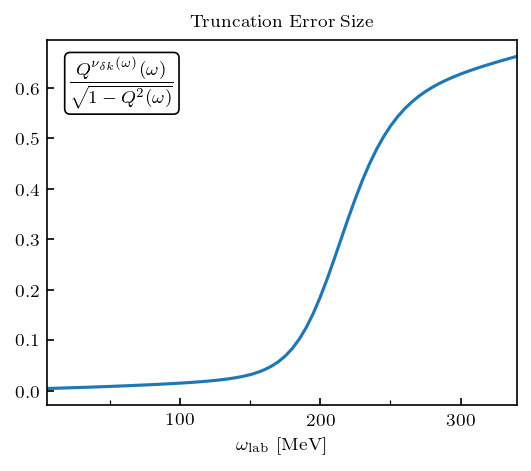

In [24]:
# Figure 11

fig, ax = plt.subplots(1,1, figsize=(3.4, 3))
ax.plot(omega, Q_vs_omega**omitted_order / np.sqrt(1 - Q_vs_omega**2))

ax.set_xticks([0, 100, 200, 300])
ax.set_xticks([50, 150, 250], minor=True)
ax.margins(x=0)
ax.text(
    0.05, 0.95, r'$\displaystyle\frac{Q^{\nu_{\delta k}(\omega)}(\omega)}{\sqrt{1 - Q^2(\omega)}}$',
    ha='left', va='top', transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='w')
)
ax.set_xlabel(r'$\omega_{\mathrm{lab}}$ [MeV]')
ax.set_title('Truncation Error Size')
fig.savefig('manuscript_figures/truncation_error_stdv')

In [25]:
# Q_no_correction = expansion_parameter_momentum_transfer_cm(X, Lambdab, mass_proton, include_correction=False)
# Q_no_correction = expansion_parameter_cm(X, Lambdab, mass_proton, factor=1.5)
Q_no_correction = expansion_parameter_cm(X, Lambdab, mass=mass_proton, factor=0.5)
Q_phil = np.broadcast_to(expansion_parameter_phillips(Lambdab), X.shape[0])
Q_correction = expansion_parameter_momentum_transfer_cm(X, Lambdab, mass_proton, include_correction=True)

Q_no_correction_mat = Q_no_correction.reshape(len(omega), len(theta))
Q_correction_mat = Q_correction.reshape(len(omega), len(theta))

# Q_no_correction_sum_mat = compute_expansion_summation_matrix(Q_no_correction, omitted_order)
# Q_correction_sum_mat = compute_expansion_summation_matrix(Q_correction, omitted_order)

# Do not include correlations
Q_no_correction_sum_mat = Q_no_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_no_correction_mat**2)
Q_correction_sum_mat = Q_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_correction_mat**2)

In [26]:
Q_no_correction_sum_mat.shape

(74, 37)

In [27]:
Q_no_correction.shape

(2738,)

In [28]:
Q_correction.shape

(2738,)

In [29]:
Q_phil.max()

0.4607685886729827

/Users/furnstah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



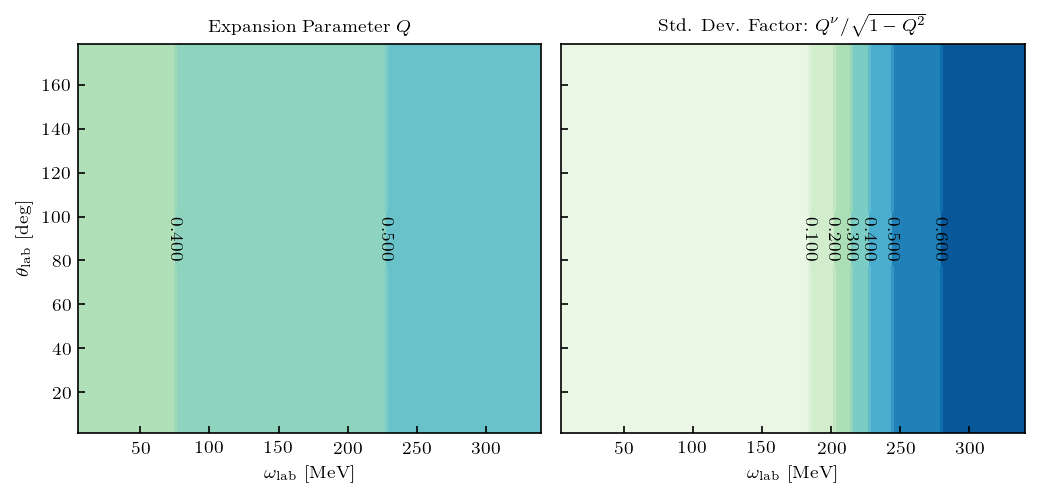

In [30]:
Q_contours = np.linspace(0, 1, 11)

cmap_Q = 'GnBu'

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)

axes[1].contourf(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)

axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')

fig.tight_layout()

In [31]:
0.7**2 / (1 - 0.7**2)

0.96078431372549

/Users/furnstah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



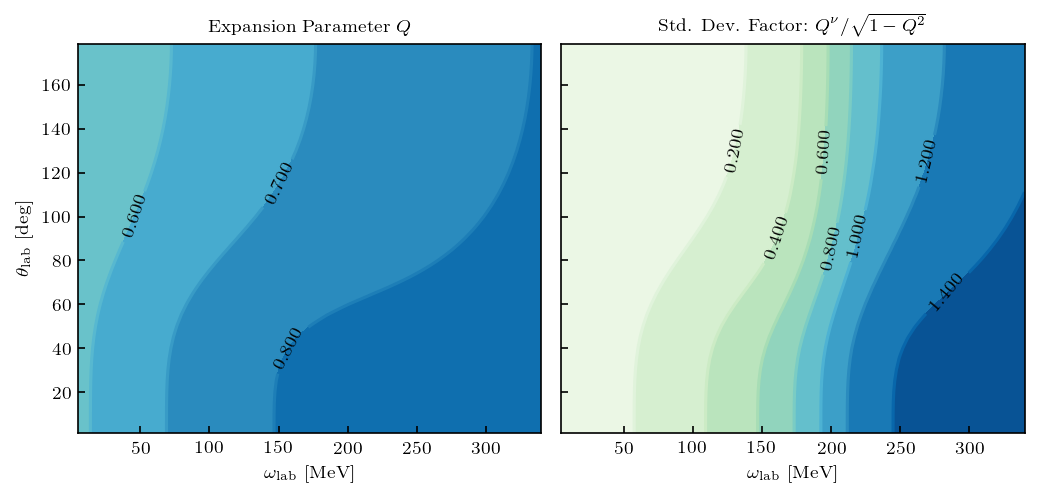

In [32]:
Q_contours = np.linspace(0, 1, 11)

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
axes[1].contourf(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)

# axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[0].clabel(CS, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
# plt.clabel()
fig.tight_layout()
fig.savefig('expansion_parameter_with_lorentz')

In [33]:
height

300

In [34]:
system = 'proton'
obs = dsg_label
obs_no_tex = observables_name_inverse_map[obs]
height = kernel_kwargs[obs_no_tex, system]['height']
df_i = df[(df['observable'] == obs) & (df['nucleon'] == system)]
X = df_i[['omegalab [MeV]', 'thetalab [deg]']].values
y = df_i[['y0', 'y2', 'y3', 'y4']].values

ref = 1.
if obs == dsg_label:
    ref = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values

if system == 'proton' and obs == dsg_label:
    dsg_scale_lorentz = ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
    ref = ref * dsg_scale_lorentz
else:
    pass

y_grid = y.reshape(len(omega), len(theta), -1)


mass = mass_proton if system == 'proton' else mass_neutron
Q = expansion_parameter_transfer_cm(X, Lambdab, mass, include_correction=False)

ord_vals = np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T
coeffs = coefficients(y, ratio=Q, orders=ord_vals, ref=ref)
coeffs_grid = coeffs.reshape(len(omega), len(theta), -1)

# fig, axes = plt.subplots(2, 2, figsize=(3.4, 3.4), sharex='col')
# axes[0, 0].plot(omega, np.squeeze(coeffs_grid[:, theta == 30]))
# axes[1, 0].plot(omega, np.squeeze(coeffs_grid[:, theta == 90]))
# axes[0, 1].plot(theta, np.squeeze(coeffs_grid[omega == 50, :]))
# axes[1, 1].plot(theta, np.squeeze(coeffs_grid[omega == 200, :]))
fig, axes = plt.subplots(1, 2, figsize=(3.4, 2.15), sharex='col', sharey=True)
theta_plot = 90
omega_plot = 50
for i, n in enumerate(orders):
    label = fr'$c_{n}$'
    axes[0].plot(omega, np.squeeze(coeffs_grid[:, theta == theta_plot, i]), label=label)
    axes[1].plot(theta, np.squeeze(coeffs_grid[omega == omega_plot, :, i]))
axes[0].set_xlabel(r'$\omega$ [MeV]')
axes[1].set_xlabel(r'$\theta$ [deg]')
axes[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axes[0].set_ylim([-1, 1])
axes[0].legend()
bbox = dict(facecolor='w', boxstyle='round', alpha=1)
axes[0].text(
    0.94, 0.06, fr'$\theta = {theta_plot}^\circ$',
    ha='right', va='bottom', transform=axes[0].transAxes,
    bbox=bbox
)
axes[1].text(
    0.94, 0.06, fr'$\omega = {omega_plot}$ MeV',
    ha='right', va='bottom', transform=axes[1].transAxes,
    bbox=bbox
)

fig.savefig(f'coefficient_figures/coeffs_{obs_no_tex}_{system}_manuscript')



NameError: name 'width' is not defined

In [36]:
import gsum as gm

In [37]:
from compton.convergence import expansion_parameter_cm

In [38]:
np.array([order_transition(order, order_map[order], X[:, 0]) for order in orders]).T

array([[ 0.        ,  1.9999039 ,  2.99961559,  3.9998078 ],
       [ 0.        ,  1.9999039 ,  2.99961559,  3.9998078 ],
       [ 0.        ,  1.9999039 ,  2.99961559,  3.9998078 ],
       ...,
       [ 0.        ,  1.00055278, -0.99778889,  2.00110556],
       [ 0.        ,  1.00055278, -0.99778889,  2.00110556],
       [ 0.        ,  1.00055278, -0.99778889,  2.00110556]])

In [39]:
from compton.convergence import ConvergenceAnalyzer

In [40]:
systems

['Neutron', 'Proton']

In [41]:
omega

array([  5.       ,  10.       ,  15.       ,  20.       ,  25.       ,
        30.       ,  35.       ,  40.       ,  45.       ,  50.       ,
        55.       ,  60.       ,  65.       ,  70.       ,  75.       ,
        80.       ,  85.       ,  90.       ,  95.       , 100.       ,
       105.       , 110.       , 115.       , 120.       , 125.       ,
       130.       , 135.       , 140.       , 145.       , 147.       ,
       148.       , 149.       , 149.9506926, 151.       , 152.       ,
       153.       , 157.       , 160.       , 165.       , 170.       ,
       175.       , 180.       , 185.       , 190.       , 195.       ,
       200.       , 205.       , 210.       , 215.       , 220.       ,
       225.       , 230.       , 235.       , 240.       , 245.       ,
       250.       , 255.       , 260.       , 265.       , 270.       ,
       275.       , 280.       , 285.       , 290.       , 295.       ,
       300.       , 305.       , 310.       , 315.       , 320. 

In [42]:
theta

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 179])

In [43]:
train_low_energies = [50, 75, 100, 125]
# train_high_energies = [175, 200, 225, 250, 275, 300]
train_high_energies = [200, 225, 250]
train_degrees = [30, 50, 70, 90, 110, 130]
train_all = np.isin(X[:,0], train_low_energies + train_high_energies) & np.isin(X[:, 1], train_degrees)
train_above_cusp = np.isin(X[:,0], train_high_energies) & np.isin(X[:, 1], train_degrees)

In [44]:
train_all.sum()

42

In [45]:
train_above_cusp.sum()

18

In [46]:
observables_unique

array(['$\\mathrm{d}\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$',
       '$\\Sigma_{2x}$', '$\\Sigma_{2z}$', '$\\Sigma_{3}$',
       '$\\Sigma_{y}$', '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$",
       "$\\Sigma_{1x'}$", "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$",
       "$\\Sigma_{2z'}$"], dtype='<U18')

In [47]:
observables_name_inverse_map

{'$\\mathrm{d}\\sigma$': 'dsg',
 '$\\Sigma_{1x}$': '1X',
 '$\\Sigma_{1z}$': '1Z',
 '$\\Sigma_{2x}$': '2X',
 '$\\Sigma_{2z}$': '2Z',
 '$\\Sigma_{3}$': '3',
 '$\\Sigma_{y}$': 'Y',
 '$\\Sigma_{3y}$': '3Y',
 "$\\Sigma_{3y'}$": '3Yp',
 "$\\Sigma_{1x'}$": '1Xp',
 "$\\Sigma_{1z'}$": '1Zp',
 "$\\Sigma_{2x'}$": '2Xp',
 "$\\Sigma_{2z'}$": '2Zp'}

In [48]:
# nonzero_below_threshold = ['2X', '2Z', '2Xp', '2Zp', '3']
# nonzero_at_leading_order = ['3', 'dsg']

# zero_at_t_0_and_180 = ['1X', '1Z', '2X', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp']
# c_deriv_zero_at_t0 = ['1Z', '3', '1Xp']
# c_deriv_zero_at_t180 = ['1Z', '2X', '3', '1Zp']

nonzero_below_threshold = ['2X', '2Z', '2Xp', '2Zp', '3']
nonzero_at_leading_order = ['3', 'dsg']

zero_at_t_0_and_180 = ['1X', '1Z', '2X', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp']
c_deriv_zero_at_t0 = ['1Z', '3', '1Xp', '2Z', '2Xp', 'dsg']
c_deriv_zero_at_t180 = ['1Z', '3', '1Zp', '2Z', '2Zp', 'dsg']

In [49]:
orders

array([0, 2, 3, 4])

In [50]:
breakdown = 650

In [51]:
import gsum as gm

In [52]:
from compton.convergence import RBFJump, ConditionalKernel
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [53]:
orders

array([0, 2, 3, 4])

In [54]:
rbf1 = RBF([1, np.inf])
rbf2 = RBF([np.inf, 2.3])
rbf3 = RBF([1, 2.3])

rbf_both = rbf1 * rbf2

In [55]:
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 179.]])

In [56]:
np.allclose(rbf3(X), rbf_both(X))

True

In [58]:
kern_test = gptools.SquaredExponentialKernel(
            initial_params=[1, 1], fixed_params=[True, True])
gp = gptools.GaussianProcess(kern_test)
gp.add_data(np.array([[0], [0]]), np.array([0, 0]), n=np.array([0, 1]))

In [59]:
dsg_label

'$\\mathrm{d}\\sigma$'

## Coefficient slices (figs. 12-18)<a id="coefficient_slices"></a>

height 4
dsg [50, 75, 100, 125, 200, 225, 250]
(42, 3)
Fit kernel: RBFJump(length_scale=[53.5, 56.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5856178495567604
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



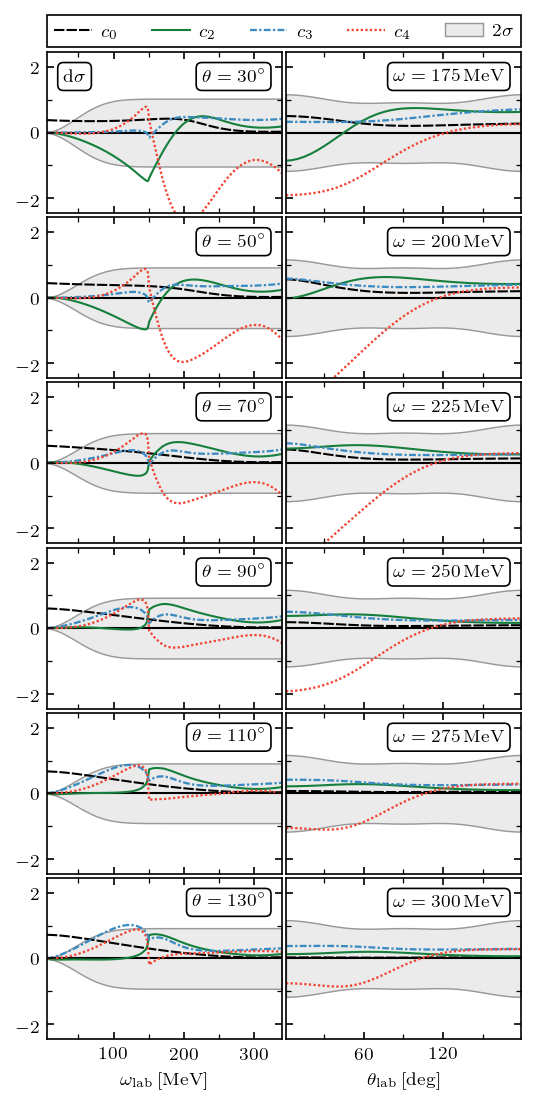

(42, 3)
Fit kernel: RBFJump(length_scale=[49.8, 58.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6345952754717062
dsg [50, 75, 100, 125, 200, 225, 250]
(42, 3)
Fit kernel: RBFJump(length_scale=[54.4, 79.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 2.8177990511915816
(42, 3)
Fit kernel: RBFJump(length_scale=[47.3, 78.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 2.482009352147663
1X [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[49, 47.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6053958591365802


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



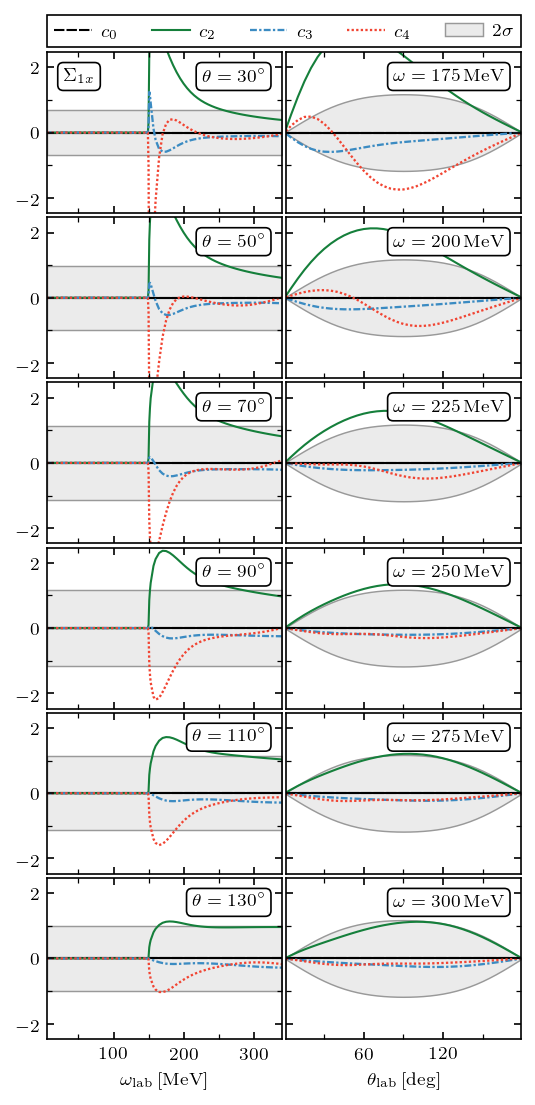

(18, 3)
Fit kernel: RBFJump(length_scale=[49.6, 46.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6586747174839749
1X [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[91.4, 46.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.47327502266203014
(18, 3)
Fit kernel: RBFJump(length_scale=[88.7, 45.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5120971847013092
1Z [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[51.4, 53.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.36964305466292874


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



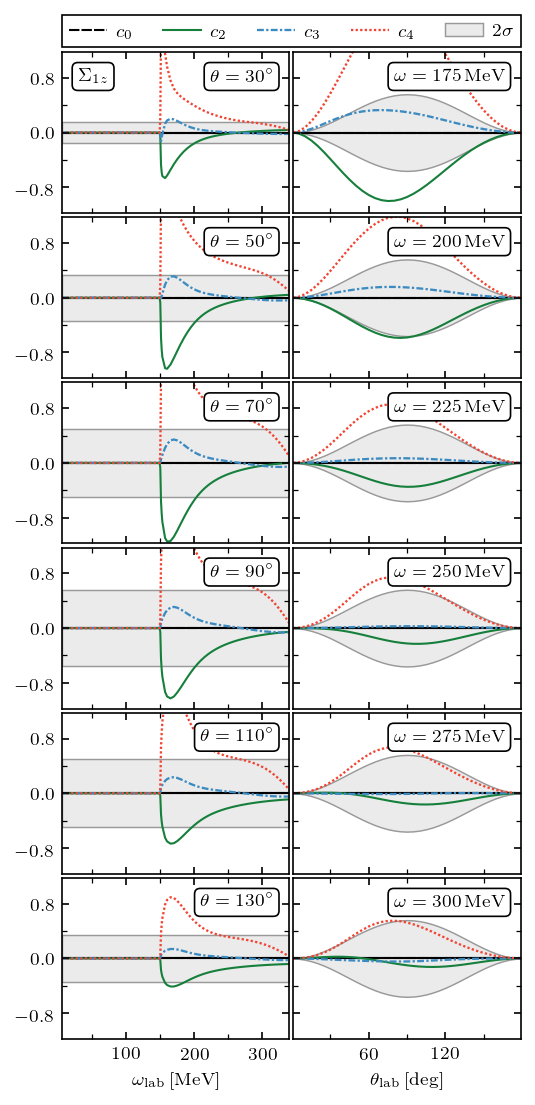

(18, 3)
Fit kernel: RBFJump(length_scale=[53.9, 52.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4230066638631868
1Z [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[92.1, 43.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.31834715502139377
(18, 3)
Fit kernel: RBFJump(length_scale=[93.3, 43]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.3568199461493507
2X [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[43, 38.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4249978629235683
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



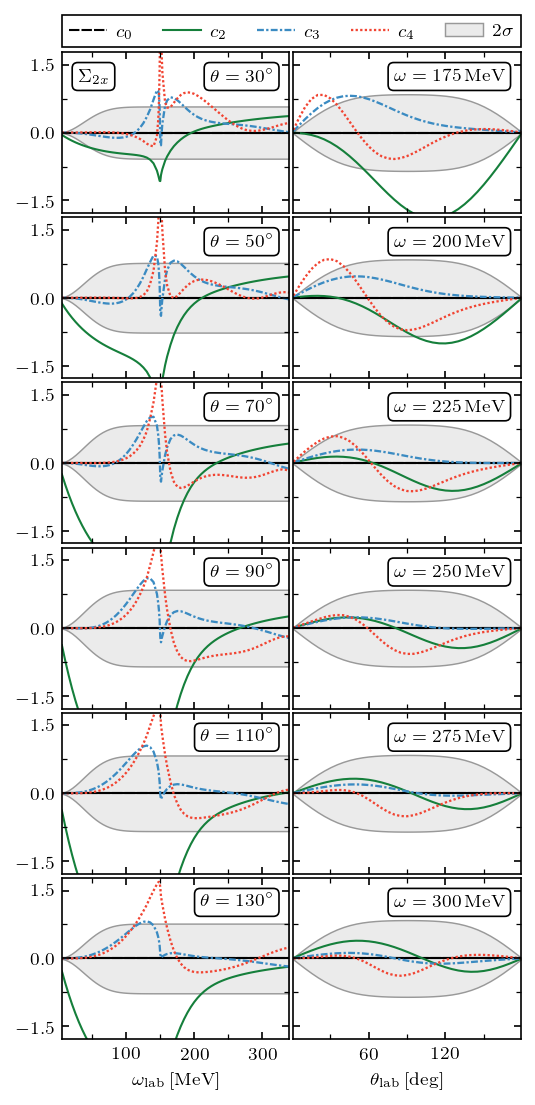

(42, 2)
Fit kernel: RBFJump(length_scale=[44.8, 37.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4266741641468729
2X [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[55.6, 39.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5744577831218587
(42, 2)
Fit kernel: RBFJump(length_scale=[52.3, 37.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5280840741825935
2Z [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[50.5, 44.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.034550447599459
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



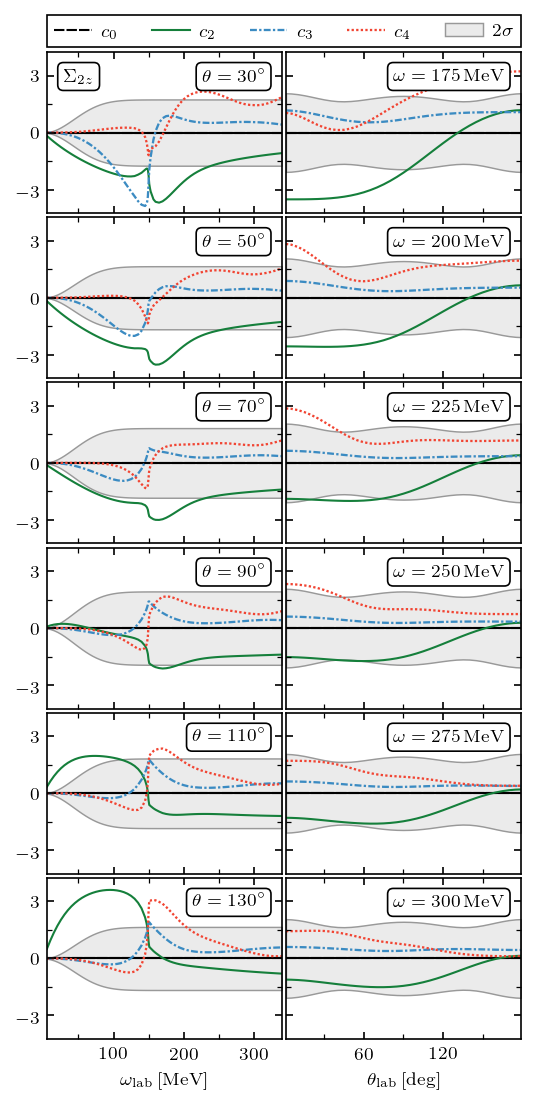

(42, 2)
Fit kernel: RBFJump(length_scale=[51.3, 43.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.0478894703703063
2Z [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[58.4, 51.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.6442922380804779
(42, 2)
Fit kernel: RBFJump(length_scale=[54.5, 51.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.503285478546941
3 [50, 75, 100, 125, 200, 225, 250]
(42, 3)
Fit kernel: RBFJump(length_scale=[54.5, 34.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5985888970538892
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



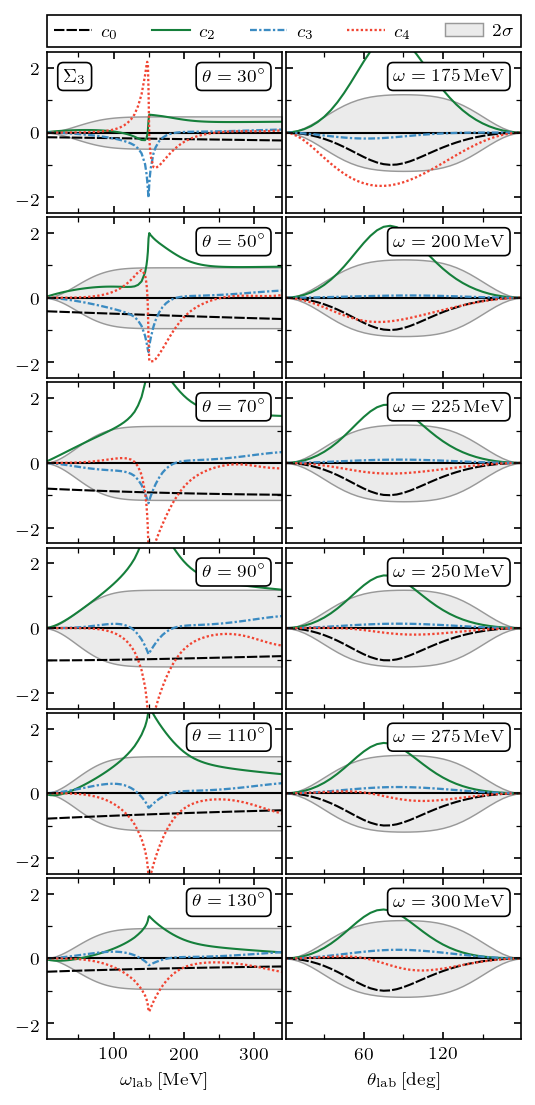

(42, 3)
Fit kernel: RBFJump(length_scale=[55.4, 35.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6024271243964743
3 [50, 75, 100, 125, 200, 225, 250]
(42, 3)
Fit kernel: RBFJump(length_scale=[70.8, 43.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.44101986166113194
(42, 3)
Fit kernel: RBFJump(length_scale=[70.8, 41]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.34600757213236627
Y [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[61.3, 52.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4667716612928191


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



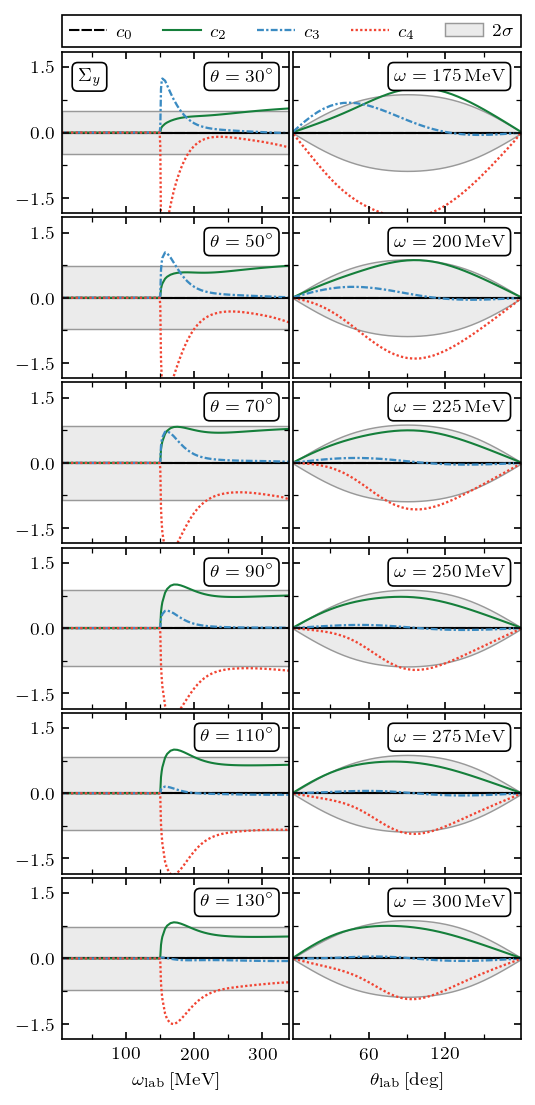

(18, 3)
Fit kernel: RBFJump(length_scale=[62.4, 51.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5270746434090609
Y [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[94.8, 42.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4159548706749588
(18, 3)
Fit kernel: RBFJump(length_scale=[94.3, 42.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.48770777982251634
3Y [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[50.3, 48.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6430591465330543


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



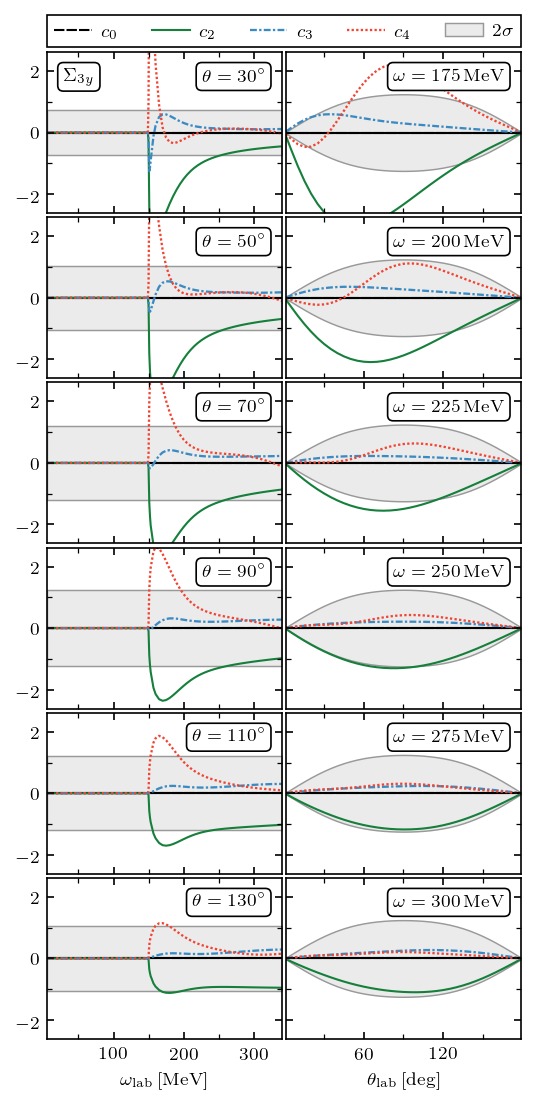

(18, 3)
Fit kernel: RBFJump(length_scale=[50.9, 47.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7027030453230656
3Y [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[90.4, 44.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4608884712729775
(18, 3)
Fit kernel: RBFJump(length_scale=[87.9, 44]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4978643759428761
3Yp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[63.8, 46.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4892775860222369


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



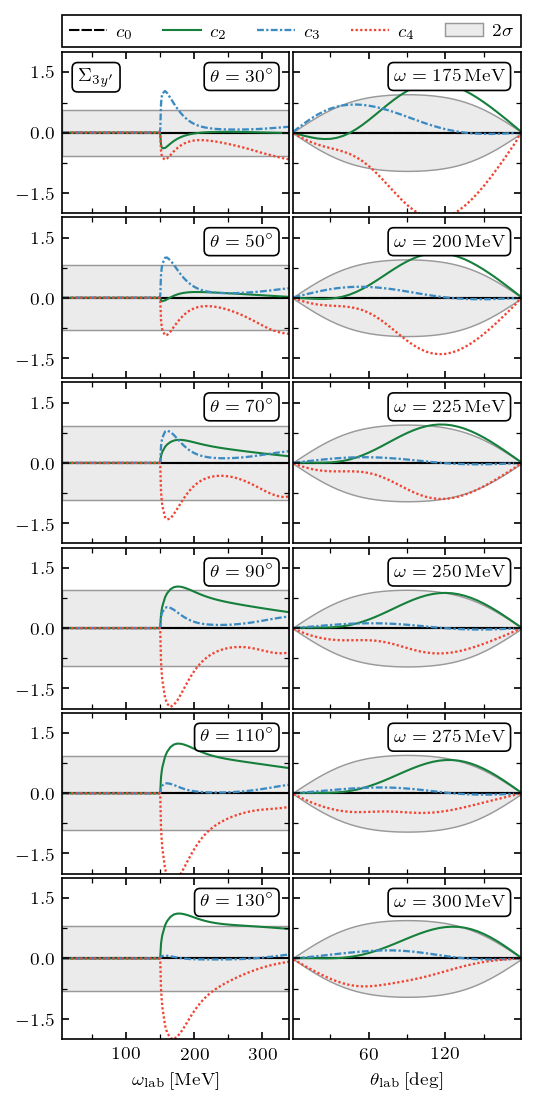

(18, 3)
Fit kernel: RBFJump(length_scale=[66, 45.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5474265525164197
3Yp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[78.8, 46.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4745485645342089
(18, 3)
Fit kernel: RBFJump(length_scale=[78.8, 46.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5429834951586123
1Xp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[55.7, 47.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5132238327610383


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



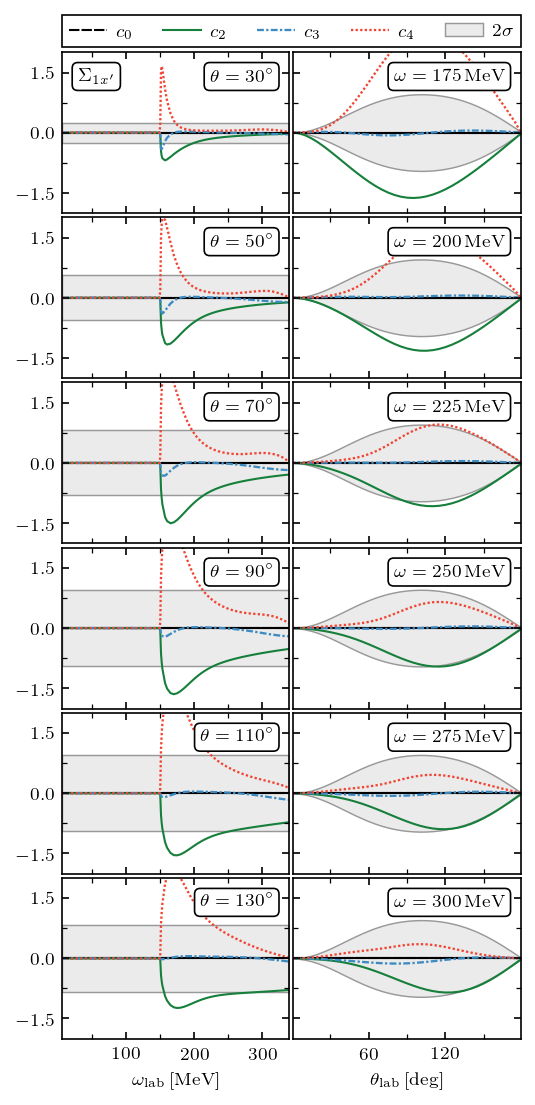

(18, 3)
Fit kernel: RBFJump(length_scale=[57.7, 47.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5742371772285823
1Xp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[75.7, 40.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.31008852506920204
(18, 3)
Fit kernel: RBFJump(length_scale=[74.3, 40.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.35706082015744545
1Zp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[51.2, 45.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.24156943381134624


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



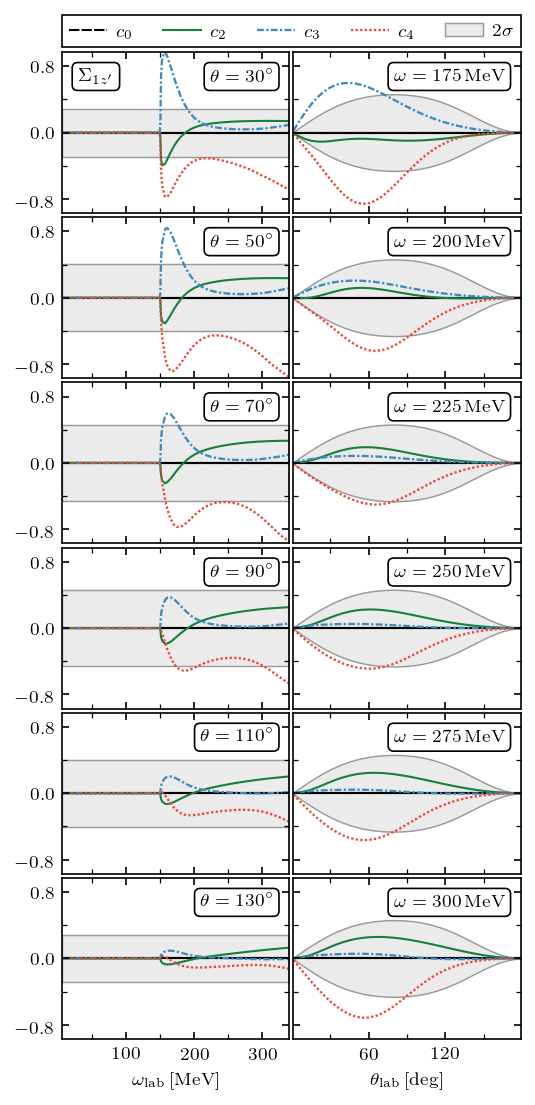

(18, 3)
Fit kernel: RBFJump(length_scale=[50.9, 44.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.26258250166733216
1Zp [200, 225, 250]
(18, 3)
Fit kernel: RBFJump(length_scale=[82.3, 44.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.2518091730347783
(18, 3)
Fit kernel: RBFJump(length_scale=[81.1, 43.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.2656948563558868
2Xp [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[33, 56]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.9086489217226025
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



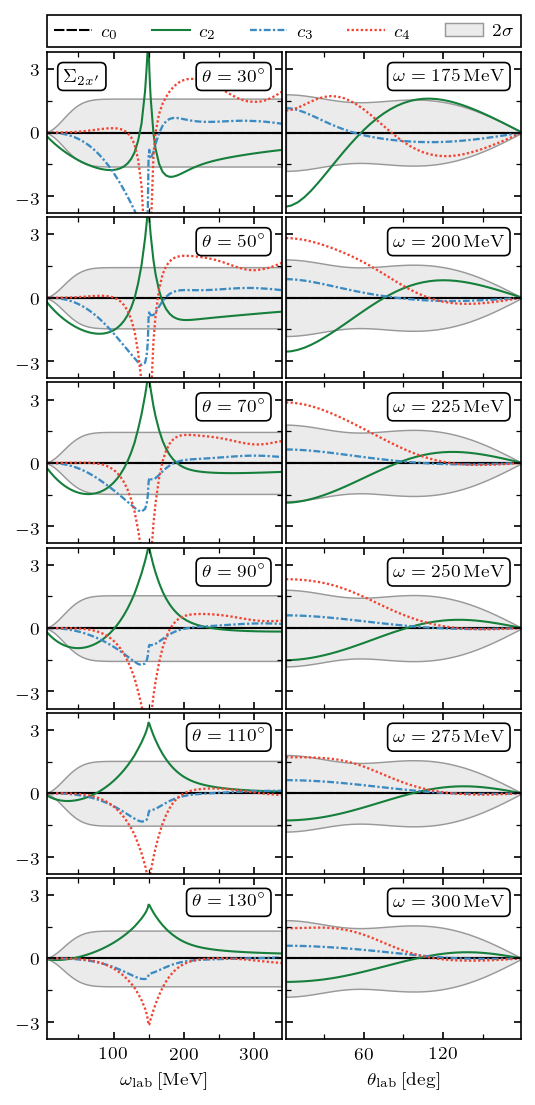

(42, 2)
Fit kernel: RBFJump(length_scale=[33.5, 57.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.8933110690902283
2Xp [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[44.1, 52.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.9492963351739424
(42, 2)
Fit kernel: RBFJump(length_scale=[46.2, 52.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.990331631539401
2Zp [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[37.9, 47.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5215573536584257
[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



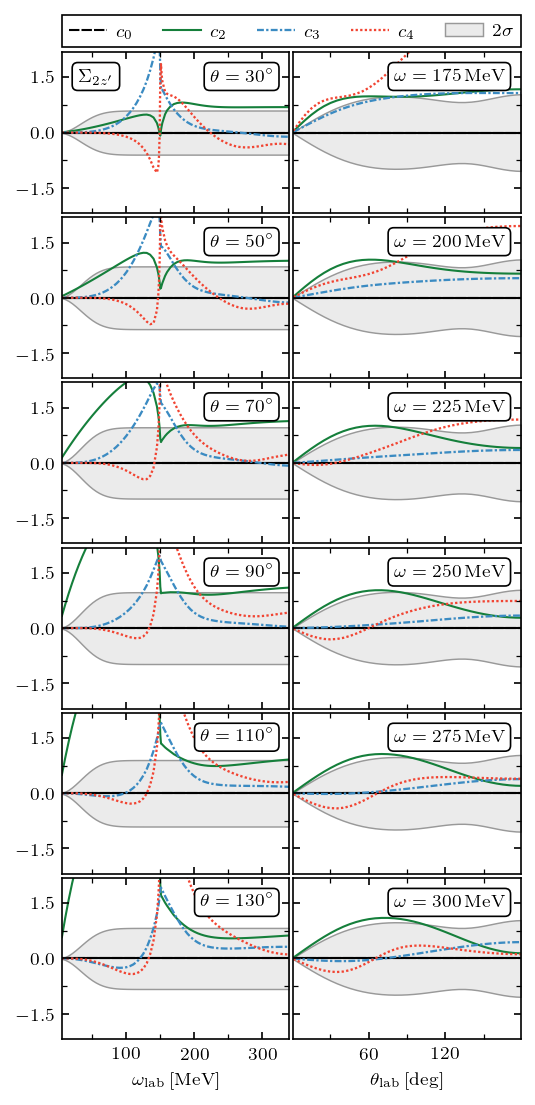

(42, 2)
Fit kernel: RBFJump(length_scale=[39.7, 49.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5585844852798089
2Zp [50, 75, 100, 125, 200, 225, 250]
(42, 2)
Fit kernel: RBFJump(length_scale=[71.6, 54.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.3931587236423415
(42, 2)
Fit kernel: RBFJump(length_scale=[69.2, 54.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.3433977182793002


In [60]:
analyzers = {}
analyzers_phillips_Q = {}

for obs, system in product(observables_unique, ['proton', 'neutron']):
    obs_no_tex = observables_name_inverse_map[obs]
        
    df_i = df[(df['observable'] == obs) & (df['nucleon'] == system)]
    X = df_i[['omegalab [MeV]', 'thetalab [deg]']].values
    y = df_i[['y0', 'y2', 'y3', 'y4']].values
    
    degrees_zeros = None
    omega_zeros = None
    omega_deriv_zeros = None
    if obs_no_tex in zero_at_t_0_and_180:
        degrees_zeros = [0, 180]
    elif obs_no_tex in ['2Xp']:
        degrees_zeros = [180]
    elif obs_no_tex in ['2Zp']:
        degrees_zeros = [0]
        
    degrees_deriv_zeros = None
    if obs_no_tex in c_deriv_zero_at_t0 and obs_no_tex in c_deriv_zero_at_t180:
        degrees_deriv_zeros = [0, 180]
    elif obs_no_tex in c_deriv_zero_at_t0:
        degrees_deriv_zeros = [0]
    elif obs_no_tex in c_deriv_zero_at_t180:
        degrees_deriv_zeros = [180]

    if obs == dsg_label or obs_no_tex in nonzero_below_threshold:
        omega_zeros = [0]
        omega_deriv_zeros = [0]

    ref = 1.
    if obs == dsg_label:
        ref = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values

        if system == 'proton':
            height = kernel_kwargs[obs_no_tex, system]['height']
            print('height', height)
            height = 4
            width = 350
            width_degrees = 90
#             width = 150 if obs == dsg_label else 50
#             width_degrees = 90 if obs == dsg_label else np.inf
            dsg_scale_lorentz = ref_scale(X[:, 0], omega_lab_cusp, X[:, 1], height=height, width=width, degrees_width=width_degrees)
            ref = ref * dsg_scale_lorentz
    
    if (obs_no_tex not in nonzero_below_threshold) and obs != dsg_label:
        train = train_above_cusp
        omegas = [175, 200, 225, 250, 275, 300]
        print(obs_no_tex, train_high_energies, flush=True)
    else:
        train = train_all
        omegas = [175, 200, 225, 250, 275, 300]
        print(obs_no_tex, train_low_energies + train_high_energies, flush=True)
        
    thetas = train_degrees
        
    if (obs_no_tex not in nonzero_below_threshold) or (obs_no_tex in nonzero_at_leading_order):
        excluded = [0]
    else:
        excluded = [0, 2]
        
        
    kern_nugget = 1e-4
    kernel = RBFJump(
        length_scale=[100, 50], length_scale_bounds=(1, 200),
        jump=[omega_lab_cusp, np.inf],
    ) + WhiteKernel(kern_nugget, 'fixed')
    
#     if degrees_zeros is None and omega_zeros is None:
#         kernel = RBFJump(
#             length_scale=[100, 50], length_scale_bounds=(1, 200),
#             jump=[omega_lab_cusp, np.inf],
#         ) + WhiteKernel(kern_nugget, 'fixed')
#     else:
#         Xt_zeros = None
#         Xo_zeros = None
#         if degrees_zeros is not None:
#             Xt_zeros = np.array(degrees_zeros)[:, None]
#         if omega_zeros is not None:
#             Xo_zeros = np.array(omega_zeros)[:, None]

            
#         kernel_theta = ConditionalKernel(
#                 50, length_scale_bounds=(1, 120), X=Xt_zeros, dim=1)
#         kernel_omega = ConditionalKernel(
#                 100, length_scale_bounds=(10, 150), X=Xo_zeros, dim=0, jump=omega_lab_cusp)
#         kernel = kernel_omega * kernel_theta + WhiteKernel(kern_nugget, 'fixed')
    
    
    use_delta_transition = True
    
    # The degrees of freedom impacts the factor posterior values
    gp_df = 1
    
    analyzer = ConvergenceAnalyzer(
        obs, system.capitalize(), X, y, orders, train=train, ref=ref,
        delta_transition=use_delta_transition,
        breakdown=breakdown, excluded=excluded, kernel=kernel, n_restarts_optimizer=0,
        df=gp_df, exp_param='halfsum', degrees_zeros=degrees_zeros, omega_zeros=omega_zeros,
        omega_deriv_zeros=omega_deriv_zeros, degrees_deriv_zeros=degrees_deriv_zeros,
    )
    analyzers[obs, system.capitalize()] = analyzer
    if system == 'proton':
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
            analyzer.plot_coefficient_slices(omegas, thetas)
            fig = plt.gcf()
            fig.savefig(f'manuscript_figures/coeffs_slices_{obs_no_tex}')
            plt.show()
        
        
    analyzer_phil = ConvergenceAnalyzer(
        obs, system.capitalize(), X, y, orders, train=train, ref=ref,
        delta_transition=use_delta_transition,
        breakdown=breakdown, exp_param='phillips', excluded=excluded, kernel=kernel,
        df=gp_df
    )
    analyzers_phillips_Q[obs, system.capitalize()] = analyzer_phil
#     break

In [61]:
data_gps = []
for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    analyzer = analyzers[obs, nucleon]
    
    cbar = analyzer.cbar
    ls_w, ls_t = analyzer.gp.kernel_.k1.get_params()['length_scale']
    
    data_gps.append([obs, cbar, ls_w, ls_t, nucleon])

In [62]:
df_gps = pd.DataFrame(data_gps, columns=['obs', 'cbar', 'ls omega', 'ls theta', 'nucleon'])
df_gps = df_gps.set_index('obs')
df_gps.index = pd.Categorical(df_gps.index, observables_unique, ordered=True)

In [63]:
df_gps

,cbar,ls omega,ls theta,nucleon
$\mathrm{d}\sigma$,0.585618,53.507205,56.176629,Proton
$\mathrm{d}\sigma$,2.817799,54.382647,79.301555,Neutron
$\Sigma_{1x}$,0.605396,49.031521,47.733200,Proton
$\Sigma_{1x}$,0.473275,91.372023,46.400217,Neutron
$\Sigma_{1z}$,0.369643,51.389460,53.175789,Proton
$\Sigma_{1z}$,0.318347,92.060948,43.208843,Neutron
$\Sigma_{2x}$,0.424998,42.995932,38.206342,Proton
$\Sigma_{2x}$,0.574458,55.564259,39.132044,Neutron
$\Sigma_{2z}$,1.034550,50.467476,44.192487,Proton
$\Sigma_{2z}$,1.644292,58.442704,51.709395,Neutron


In [64]:
df_gps_pivot = df_gps.pivot(columns='nucleon').swaplevel(0, 1, axis=1).sort_values('nucleon', axis=1, ascending=False)
df_gps_pivot

nucleon               Proton                         Neutron             \
                        cbar   ls omega   ls theta      cbar   ls omega   
$\mathrm{d}\sigma$  0.585618  53.507205  56.176629  2.817799  54.382647   
$\Sigma_{1x}$       0.605396  49.031521  47.733200  0.473275  91.372023   
$\Sigma_{1z}$       0.369643  51.389460  53.175789  0.318347  92.060948   
$\Sigma_{2x}$       0.424998  42.995932  38.206342  0.574458  55.564259   
$\Sigma_{2z}$       1.034550  50.467476  44.192487  1.644292  58.442704   
$\Sigma_{3}$        0.598589  54.497640  34.545112  0.441020  70.773732   
$\Sigma_{y}$        0.466772  61.324164  52.379791  0.415955  94.787076   
$\Sigma_{3y}$       0.643059  50.300427  48.124554  0.460888  90.444550   
$\Sigma_{3y'}$      0.489278  63.804479  46.164070  0.474549  78.829830   
$\Sigma_{1x'}$      0.513224  55.657398  47.783697  0.310089  75.746917   
$\Sigma_{1z'}$      0.241569  51.235589  45.074081  0.251809  82.261949   
$\Sigma_{2x'}$      0.908649  32.955046  56.022555  0.949296  44.062829   
$\Sigma_{2z'}$      0.521557  37.905068  47.287607  1.393159  71.603583   

nucleon                        
                     ls theta  
$\mathrm{d}\sigma$  79.301555  
$\Sigma_{1x}$       46.400217  
$\Sigma_{1z}$       43.208843  
$\Sigma_{2x}$       39.132044  
$\Sigma_{2z}$       51.709395  
$\Sigma_{3}$        43.212834  
$\Sigma_{y}$        42.851352  
$\Sigma_{3y}$       44.252843  
$\Sigma_{3y'}$      46.121902  
$\Sigma_{1x'}$      40.829127  
$\Sigma_{1z'}$      44.133616  
$\Sigma_{2x'}$      52.526364  
$\Sigma_{2z'}$      54.598569

In [65]:
df_gps_pivot = df_gps.pivot(columns='nucleon').swaplevel(0, 1, axis=1).sort_values('nucleon', axis=1, ascending=False)
df_gps_pivot

nucleon               Proton                         Neutron             \
                        cbar   ls omega   ls theta      cbar   ls omega   
$\mathrm{d}\sigma$  0.585618  53.507205  56.176629  2.817799  54.382647   
$\Sigma_{1x}$       0.605396  49.031521  47.733200  0.473275  91.372023   
$\Sigma_{1z}$       0.369643  51.389460  53.175789  0.318347  92.060948   
$\Sigma_{2x}$       0.424998  42.995932  38.206342  0.574458  55.564259   
$\Sigma_{2z}$       1.034550  50.467476  44.192487  1.644292  58.442704   
$\Sigma_{3}$        0.598589  54.497640  34.545112  0.441020  70.773732   
$\Sigma_{y}$        0.466772  61.324164  52.379791  0.415955  94.787076   
$\Sigma_{3y}$       0.643059  50.300427  48.124554  0.460888  90.444550   
$\Sigma_{3y'}$      0.489278  63.804479  46.164070  0.474549  78.829830   
$\Sigma_{1x'}$      0.513224  55.657398  47.783697  0.310089  75.746917   
$\Sigma_{1z'}$      0.241569  51.235589  45.074081  0.251809  82.261949   
$\Sigma_{2x'}$      0.908649  32.955046  56.022555  0.949296  44.062829   
$\Sigma_{2z'}$      0.521557  37.905068  47.287607  1.393159  71.603583   

nucleon                        
                     ls theta  
$\mathrm{d}\sigma$  79.301555  
$\Sigma_{1x}$       46.400217  
$\Sigma_{1z}$       43.208843  
$\Sigma_{2x}$       39.132044  
$\Sigma_{2z}$       51.709395  
$\Sigma_{3}$        43.212834  
$\Sigma_{y}$        42.851352  
$\Sigma_{3y}$       44.252843  
$\Sigma_{3y'}$      46.121902  
$\Sigma_{1x'}$      40.829127  
$\Sigma_{1z'}$      44.133616  
$\Sigma_{2x'}$      52.526364  
$\Sigma_{2z'}$      54.598569

In [66]:
print(df_gps_pivot.to_latex(escape=False, float_format='{:0.2g}'.format))

\begin{tabular}{lrrrrrr}
\toprule
nucleon & \multicolumn{3}{l}{Proton} & \multicolumn{3}{l}{Neutron} \\
{} &   cbar & ls omega & ls theta &    cbar & ls omega & ls theta \\
\midrule
$\mathrm{d}\sigma$ &   0.59 &       54 &       56 &     2.8 &       54 &       79 \\
$\Sigma_{1x}$      &   0.61 &       49 &       48 &    0.47 &       91 &       46 \\
$\Sigma_{1z}$      &   0.37 &       51 &       53 &    0.32 &       92 &       43 \\
$\Sigma_{2x}$      &   0.42 &       43 &       38 &    0.57 &       56 &       39 \\
$\Sigma_{2z}$      &      1 &       50 &       44 &     1.6 &       58 &       52 \\
$\Sigma_{3}$       &    0.6 &       54 &       35 &    0.44 &       71 &       43 \\
$\Sigma_{y}$       &   0.47 &       61 &       52 &    0.42 &       95 &       43 \\
$\Sigma_{3y}$      &   0.64 &       50 &       48 &    0.46 &       90 &       44 \\
$\Sigma_{3y'}$     &   0.49 &       64 &       46 &    0.47 &       79 &       46 \\
$\Sigma_{1x'}$     &   0.51 &       56 &       48 &  

In [67]:
df_gps.to_csv('gp_hyperparameters.csv')

In [68]:
from matplotlib.ticker import AutoMinorLocator

## Observable coefficients (fig. 1)<a id="observable_coefficients"></a>

[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



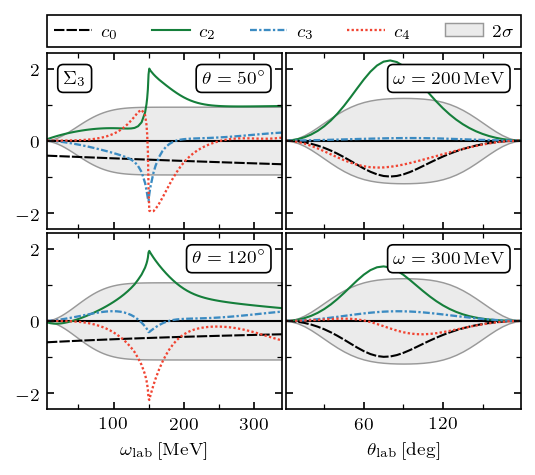

In [69]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2,2, figsize=(3.4, 3), sharex='col', sharey=True)

    obs_plot = r'$\Sigma_{3}$'
    obs_no_tex_plot = observables_name_inverse_map[obs_plot]
    analyzers[obs_plot, 'Proton'].plot_coefficient_slices([200, 300], [50, 120], axes=axes)
    axes[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    fig.savefig(f'manuscript_figures/coeffs_obs-{obs_no_tex_plot}')
    plt.show()

[[0]
 [0]] [0. 1.]


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied.  At least one axes collapsed to zero width or height.



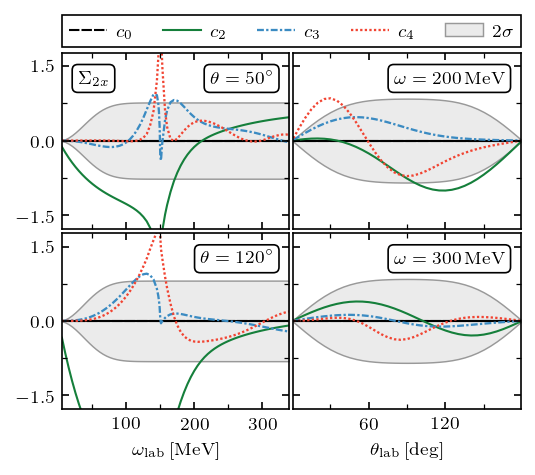

In [70]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2,2, figsize=(3.4, 3), sharex='col', sharey=True)

    obs_plot = r'$\Sigma_{2x}$'
    obs_no_tex_plot = observables_name_inverse_map[obs_plot]
    analyzers[obs_plot, 'Proton'].plot_coefficient_slices([200, 300], [50, 120], axes=axes)
    axes[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    fig.savefig(f'manuscript_figures/coeffs_obs-{obs_no_tex_plot}')
    plt.show()

In [71]:
factors = np.linspace(0.05, 3, 100)
# factors_prior = 1 / factors
factors_prior = 1

Q_posteriors_sum = {}
Q_posteriors_phil = {}
Q_bayes_factors = {}

for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    analyzer = analyzers[obs, nucleon]
    analyzer_phil = analyzers_phillips_Q[obs, nucleon]
    Q_log_post_i = np.array([analyzer.log_marginal_likelihood(factor=factor) for factor in factors])
    Q_log_post_i += np.log(factors_prior)
    Q_log_post_i_norm = Q_log_post_i - Q_log_post_i.max()
    Q_post_i_norm = np.exp(Q_log_post_i_norm) / np.trapz(np.exp(Q_log_post_i_norm), factors)
    Q_marg_like_i = np.trapz(np.exp(Q_log_post_i), factors)
    
    Q_phil_marg_like_i = np.exp(analyzer_phil.log_marginal_likelihood())

    Q_posteriors_sum[obs, nucleon] = Q_post_i_norm
    Q_posteriors_phil[obs, nucleon] = Q_phil_marg_like_i
    Q_bayes_factors[obs, nucleon] = Q_marg_like_i / Q_phil_marg_like_i

/Users/furnstah/anaconda3/lib/python3.6/site-packages/gsum/models.py:882: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.16534504e-05, -7.55823248e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}

/Users/furnstah/anaconda3/lib/python3.6/site-packages/gsum/models.py:882: ConvergenceWarning:

fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.32687545e-05, -7.90647147e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 10, 'warnflag': 2}



In [72]:
# combined_post = np.ones(factors.shape[0])
Q_posteriors_sum['All', 'Proton'] = np.ones(factors.shape[0])
Q_posteriors_sum['All', 'Neutron'] = np.ones(factors.shape[0])
for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    Q_posteriors_sum['All', nucleon] += np.log(Q_posteriors_sum[obs, nucleon])
    
Q_posteriors_sum['All', 'Proton'] -= Q_posteriors_sum['All', 'Proton'].max()
Q_posteriors_sum['All', 'Neutron'] -= Q_posteriors_sum['All', 'Neutron'].max()
Q_posteriors_sum['All', 'Proton'] = np.exp(Q_posteriors_sum['All', 'Proton'])
Q_posteriors_sum['All', 'Neutron'] = np.exp(Q_posteriors_sum['All', 'Neutron'])

In [73]:
Q_posteriors_sum

{('$\\mathrm{d}\\sigma$',
  'Proton'): array([2.63345598e-49, 6.98130265e-33, 5.49791320e-23, 2.24509568e-16,
        9.64690006e-12, 2.01716392e-08, 5.09945389e-06, 2.83997001e-04,
        5.29651965e-03, 4.45832908e-02, 2.09540255e-01, 6.39398007e-01,
        1.40913363e+00, 2.41873123e+00, 3.41266400e+00, 4.11529912e+00,
        4.36439726e+00, 4.15807950e+00, 3.61632177e+00, 2.90646734e+00,
        2.17923459e+00, 1.53570625e+00, 1.02314518e+00, 6.47512764e-01,
        3.90766444e-01, 2.25595036e-01, 1.24924827e-01, 6.65072249e-02,
        3.41078197e-02, 1.68798833e-02, 8.07430815e-03, 3.73847659e-03,
        1.67775111e-03, 7.30737897e-04, 3.09264689e-04, 1.27335255e-04,
        5.10643242e-05, 1.99676572e-05, 7.62181307e-06, 2.84305034e-06,
        1.03746234e-06, 3.70750228e-07, 1.29886734e-07, 4.46548231e-08,
        1.50810156e-08, 5.00820194e-09, 1.63698198e-09, 5.27144161e-10,
        1.67394514e-10, 5.24652799e-11, 1.62443991e-11, 4.97286900e-12,
        1.50640411e-12, 4.

In [74]:
observables_all_order = np.concatenate([['All'], observables_unique])

In [75]:
observables_all_order

array(['All', '$\\mathrm{d}\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$',
       '$\\Sigma_{2x}$', '$\\Sigma_{2z}$', '$\\Sigma_{3}$',
       '$\\Sigma_{y}$', '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$",
       "$\\Sigma_{1x'}$", "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$",
       "$\\Sigma_{2z'}$"], dtype='<U18')

In [76]:
Q_posteriors_sum_df = pd.DataFrame.from_dict(Q_posteriors_sum)
# Q_posteriors_sum_df.index.names = [r'pdf']
Q_posteriors_sum_df['Factor'] = factors
Q_posteriors_sum_df[r'$\Lambda_b$ [MeV]'] = breakdown / factors
Q_posteriors_sum_df = Q_posteriors_sum_df.set_index(['Factor', r'$\Lambda_b$ [MeV]'], drop=True)
# Q_posteriors_sum_df.index.names = ['obs', 'nucleon']
# Q_posteriors_sum_df = Q_posteriors_sum_df.reset_index()
# Q_posteriors_sum_df = Q_posteriors_sum_df.T

Q_posteriors_sum_df = Q_posteriors_sum_df.stack(level=[0, 1])
Q_posteriors_sum_df.index.names = ['Factor', r'$\Lambda_b$ [MeV]', 'obs', 'nucleon']
Q_posteriors_sum_df = Q_posteriors_sum_df.reset_index()
Q_posteriors_sum_df = Q_posteriors_sum_df.rename({0: 'pdf'}, axis=1)
Q_posteriors_sum_df['obs'] = pd.Categorical(Q_posteriors_sum_df['obs'], observables_all_order, ordered=True)
Q_posteriors_sum_df = Q_posteriors_sum_df.sort_values(by=['obs', 'Factor'])


In [77]:
Q_posteriors_sum_df

,Factor,$\Lambda_b$ [MeV],obs,nucleon,pdf
26,0.050000,13000.000000,All,Neutron,0.000000e+00
27,0.050000,13000.000000,All,Proton,0.000000e+00
54,0.079798,8145.569620,All,Neutron,0.000000e+00
55,0.079798,8145.569620,All,Proton,0.000000e+00
82,0.109596,5930.875576,All,Neutron,0.000000e+00
...,...,...,...,...,...
2729,2.940404,221.058056,$\Sigma_{2z'}$,Proton,8.511794e-12
2756,2.970202,218.840333,$\Sigma_{2z'}$,Neutron,1.150796e-28
2757,2.970202,218.840333,$\Sigma_{2z'}$,Proton,4.220731e-12
2784,3.000000,216.666667,$\Sigma_{2z'}$,Neutron,3.247403e-29


In [78]:
Q_bayes_factors

{('$\\mathrm{d}\\sigma$', 'Proton'): 72231349399478.3,
 ('$\\mathrm{d}\\sigma$', 'Neutron'): 5.4703424530252536e+16,
 ('$\\Sigma_{1x}$', 'Proton'): 46071757650687.02,
 ('$\\Sigma_{1x}$', 'Neutron'): 1673222.584699032,
 ('$\\Sigma_{1z}$', 'Proton'): 738854452133125.2,
 ('$\\Sigma_{1z}$', 'Neutron'): 457531183884.3605,
 ('$\\Sigma_{2x}$', 'Proton'): 1000732360553.5698,
 ('$\\Sigma_{2x}$', 'Neutron'): 51114415905247.164,
 ('$\\Sigma_{2z}$', 'Proton'): 23970765731.798622,
 ('$\\Sigma_{2z}$', 'Neutron'): 3.640860158094427e+16,
 ('$\\Sigma_{3}$', 'Proton'): 39154082038.79224,
 ('$\\Sigma_{3}$', 'Neutron'): 5.179509321505994,
 ('$\\Sigma_{y}$', 'Proton'): 1.7828228417286826e+16,
 ('$\\Sigma_{y}$', 'Neutron'): 23311070052.699024,
 ('$\\Sigma_{3y}$', 'Proton'): 3582208531990143.5,
 ('$\\Sigma_{3y}$', 'Neutron'): 2177655.002343583,
 ("$\\Sigma_{3y'}$", 'Proton'): 1968828836896902.5,
 ("$\\Sigma_{3y'}$", 'Neutron'): 433905419471.5303,
 ("$\\Sigma_{1x'}$", 'Proton'): 8.838886088697357e+16,
 ("$\\S

In [79]:
Q_bayes_factors_df = pd.DataFrame.from_dict(Q_bayes_factors, orient='index', )

In [80]:
Q_bayes_factors_df

,0
"($\mathrm{d}\sigma$, Proton)",7.223135e+13
"($\mathrm{d}\sigma$, Neutron)",5.470342e+16
"($\Sigma_{1x}$, Proton)",4.607176e+13
"($\Sigma_{1x}$, Neutron)",1.673223e+06
"($\Sigma_{1z}$, Proton)",7.388545e+14
"($\Sigma_{1z}$, Neutron)",4.575312e+11
"($\Sigma_{2x}$, Proton)",1.000732e+12
"($\Sigma_{2x}$, Neutron)",5.111442e+13
"($\Sigma_{2z}$, Proton)",2.397077e+10
"($\Sigma_{2z}$, Neutron)",3.640860e+16


In [81]:
import seaborn as sns

In [82]:
from compton.graphs import pdfplot

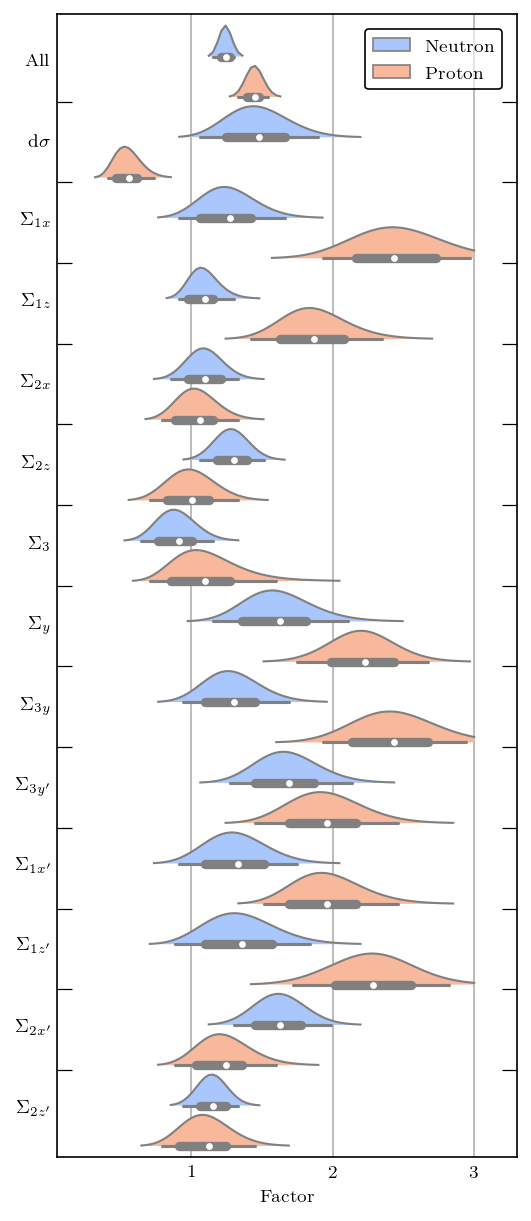

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 8))
pdfplot(
    'Factor', 'obs', 'pdf', data=Q_posteriors_sum_df, hue='nucleon',
    linewidth=1, palette='coolwarm', ax=ax, margin=0.3, 
)
ax.set_xticks([1, 2, 3])
ax.margins(y=0.01)
ax.set_xlim(factors[0], 1.1*factors[-1])
ax.grid(axis='x');
fig.savefig('Q_factor_posterior.png')

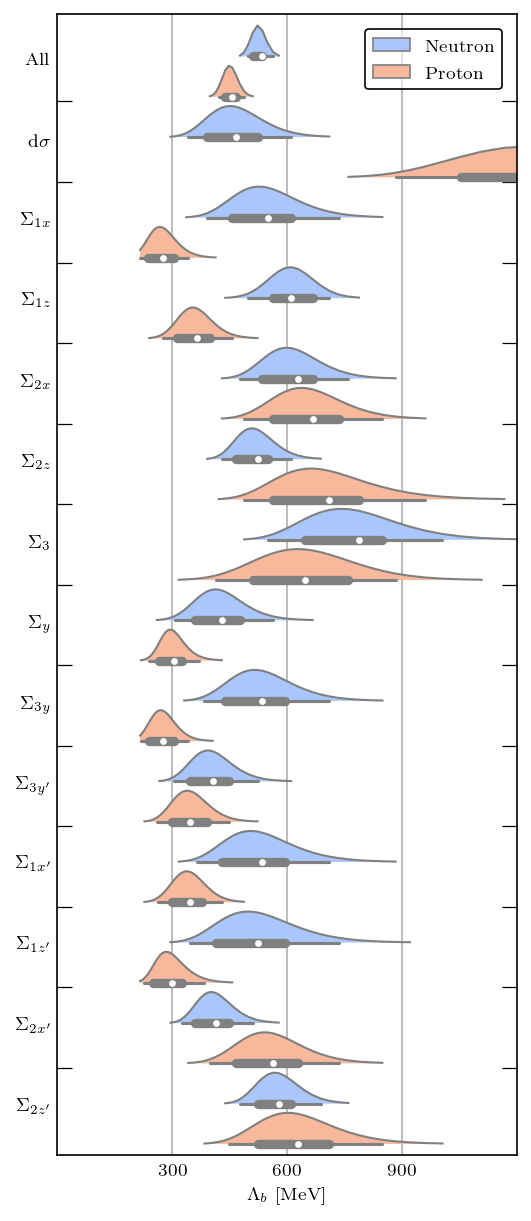

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 8))
pdfplot(
    r'$\Lambda_b$ [MeV]', 'obs', 'pdf',
    data=Q_posteriors_sum_df.sort_values(by=['obs', r'$\Lambda_b$ [MeV]']),
    hue='nucleon',
    linewidth=1, palette='coolwarm', ax=ax, margin=0.3, 
)
ax.set_xticks([300, 600, 900])
ax.margins(y=0.01)
ax.set_xlim(0, 1200)
ax.grid(axis='x');
fig.savefig('Q_breakdown_posterior.png')

In [85]:
# fig, ax = plt.subplots(1, 1, figsize=(3.4, 7))
# for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):

In [86]:
analyzers

{('$\\mathrm{d}\\sigma$',
  'Proton'): <compton.convergence.ConvergenceAnalyzer at 0x1a280222b0>,
 ('$\\mathrm{d}\\sigma$',
  'Neutron'): <compton.convergence.ConvergenceAnalyzer at 0x1a2999ba90>,
 ('$\\Sigma_{1x}$',
  'Proton'): <compton.convergence.ConvergenceAnalyzer at 0x1a2998e7b8>,
 ('$\\Sigma_{1x}$',
  'Neutron'): <compton.convergence.ConvergenceAnalyzer at 0x1a2d6282b0>,
 ('$\\Sigma_{1z}$',
  'Proton'): <compton.convergence.ConvergenceAnalyzer at 0x1af83f9e48>,
 ('$\\Sigma_{1z}$',
  'Neutron'): <compton.convergence.ConvergenceAnalyzer at 0x1af8b9dc88>,
 ('$\\Sigma_{2x}$',
  'Proton'): <compton.convergence.ConvergenceAnalyzer at 0x1af8efb8d0>,
 ('$\\Sigma_{2x}$',
  'Neutron'): <compton.convergence.ConvergenceAnalyzer at 0x1af9c27710>,
 ('$\\Sigma_{2z}$',
  'Proton'): <compton.convergence.ConvergenceAnalyzer at 0x1af9ccf320>,
 ('$\\Sigma_{2z}$',
  'Neutron'): <compton.convergence.ConvergenceAnalyzer at 0x1a297c9c88>,
 ('$\\Sigma_{3}$',
  'Proton'): <compton.convergence.Convergenc